In [1]:
import numpy as np
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras
import SimpleITK as sitk
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def train_array(path, end):
    files = glob.glob(path + end, recursive=True)
    img_list = []
    r.seed(9)
    r.shuffle(files)

    for file in files:
        img = sitk.ReadImage(file)
        img_array = sitk.GetArrayFromImage(img)  # [z, y, x] şeklinde

        img_array = (img_array - img_array.mean()) / img_array.std()
        img_array = img_array.astype('float32')

        for slice in range(60, 130):  
            if slice < img_array.shape[0]: 
                img_s = img_array[slice, :, :]
                img_s = np.expand_dims(img_s, axis=0)  # [1, y, x]
                img_list.append(img_s)

    return np.array(img_list, np.float32)



def seg_array(path, end, label):
    files = glob.glob(path + end, recursive=True)
    img_list = []
    r.seed(9)
    r.shuffle(files)
    
    for file in files:
        img = sitk.ReadImage(file)
        img_array = sitk.GetArrayFromImage(img)  # [z, y, x] şeklinde
        
       
        if label == 1:
            img_array[img_array != 0] = 1  # Tam tümör
        if label == 2:
            img_array[img_array != 1] = 0  # Nekroz
        if label == 3:
            img_array[img_array == 2] = 0  # Ödemsiz tümör
            img_array[img_array != 0] = 1
        if label == 4:
            img_array[img_array != 4] = 0  # Genişleyen tümör
            img_array[img_array == 4] = 1
        
        img_array = img_array.astype('float32')

        for slice in range(60, 130):
            if slice < img_array.shape[0]:
                img_s = img_array[slice, :, :]
                img_s = np.expand_dims(img_s, axis=0)  # [1, y, x]
                img_list.append(img_s)

    return np.array(img_list, np.float32)



In [66]:
flair = train_array(r'C:\Users\Public\BraTS\train\\', '**\\*flair.nii.gz')
t2 = train_array(r'C:\Users\Public\BraTS\train\\', '**\\*t2.nii.gz')
seg = seg_array(r'C:\Users\Public\BraTS\train\\', '**\\*seg.nii.gz',1)

In [67]:
x_train = np.concatenate((flair,t2), axis=1)

In [68]:
del t2
del flair

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


K.set_image_data_format('channels_first')



def dice_coef(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-5) / (union + 1e-5)

def precision(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + 1e-5)

def recall(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + 1e-5)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-5)

# === MODEL ===

def unet_model():
    inputs = Input((2, 240, 240))  # (channels, height, width)

    # Downsampling
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D()(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D()(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D()(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D()(conv4)

  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization(axis=1)(conv5)

    
    up6 = Conv2DTranspose(512, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization(axis=1)(conv6)

    up7 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization(axis=1)(conv7)

    up8 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization(axis=1)(conv8)

    up9 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization(axis=1)(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)  # mask çıktısı

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=dice_coef_loss,
        metrics=[dice_coef, iou_metric, precision, recall, f1_score]
    )
    return model


In [7]:
model=unet_model()

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

fold = 1
for train_index, val_index in kf.split(x_train):
    print(f"\nFold {fold} başlıyor...")

    
    model = unet_model()

  
    X_train, X_val = x_train[train_index], x_train[val_index]
    y_train, y_val = seg[train_index], seg[val_index]

  
    early_stopping = EarlyStopping(
        monitor='val_loss',  
        patience=5,  
        restore_best_weights=True,  
        verbose=1  
    )

   
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=4,  
        epochs=3,  
        shuffle=True,
        verbose=1,
        callbacks=[early_stopping]  
    )

    fold += 1


Fold 1 başlıyor...
Epoch 1/3
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 12672s 7s/step - dice_coef: 0.3007 - f1_score: 0.3942 - iou_metric: 0.2848 - loss: 0.6993 - precision: 0.2925 - recall: 0.9722 - val_dice_coef: 0.5249 - val_f1_score: 0.5277 - val_iou_metric: 0.4219 - val_loss: 0.4751 - val_precision: 0.4274 - val_recall: 0.7747
Epoch 2/3
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 12630s 7s/step - dice_coef: 0.7979 - f1_score: 0.8271 - iou_metric: 0.7290 - loss: 0.2021 - precision: 0.8083 - recall: 0.8922 - val_dice_coef: 0.6500 - val_f1_score: 0.6527 - val_iou_metric: 0.5816 - val_loss: 0.3500 - val_precision: 0.6292 - val_recall: 0.7024
Epoch 3/3
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 12710s 7s/step - dice_coef: 0.8308 - f1_score: 0.8362 - iou_metric: 0.7427 - loss: 0.1692 - precision: 0.8409 - recall: 0.8626 - val_dice_coef: 0.6371 - val_f1_score: 0.6380 - val_iou_metric: 0.7714 - val_loss: 0.3629 - val_precision: 0.7042 - val_recall: 0.6053
Restoring model weights from the end of the best epoch: 2.

Fold 2 b

In [11]:
model.save_weights('repository/tam_tumor.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 258s 258s/step


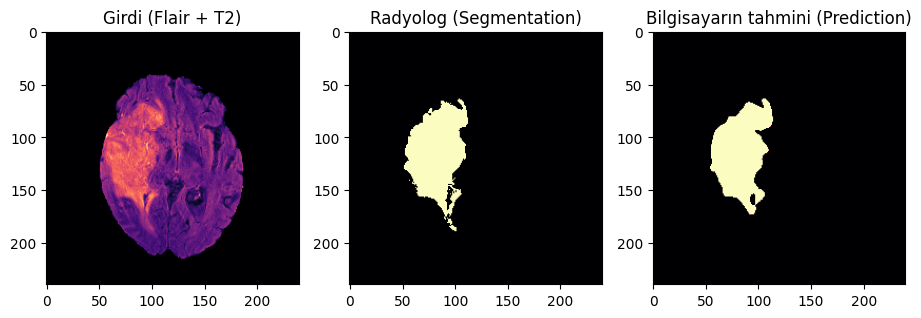

In [25]:
x = 1820
renk = {0: 'magma',
        1: 'viridis',
        2: 'gray',
        3: 'inferno',
        4: 'cividis',
        5: 'hot',}
a = 0
örnek = np.expand_dims(x_train[x],axis = 0)
pred = model.predict(örnek)

fig = plt.figure(figsize=(15,10))


plt.subplot(141)
plt.title('Girdi (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(142)
plt.title('Radyolog (Segmentation)')
plt.imshow(seg[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Bilgisayarın tahmini (Prediction)')
plt.imshow(pred[0][0],cmap = renk[a])

In [4]:
t1ce = train_array(r'C:\Users\Public\BraTS\train\\', '**\\*t1ce.nii.gz')
seg_nekroz = seg_array(r'C:\Users\Public\BraTS\train\\', '**\\*seg.nii.gz',2)
seg_ödemsiz = seg_array(r'C:\Users\Public\BraTS\train\\', '**\\*seg.nii.gz',3)
seg_geniş = seg_array(r'C:\Users\Public\BraTS\train\\', '**\\*seg.nii.gz',4)
seg_tam = seg_array(r'C:\Users\Public\BraTS\train\\', '**\\*seg.nii.gz',1)


In [5]:
def tümör_kırp(x, pred, size): 
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    index_xy = np.where(p_tmp==1)  

    if index_xy[0].shape[0] == 0: 
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy   




In [38]:
liste = []

for i in range(len(t1ce)):
    crop, kordinat = tümör_kırp(seg_nekroz[i, :, :, :], seg_tam[i, :, :, :], 64)

   
    if crop is None or (isinstance(crop, list) and len(crop) == 0):
        pass

   
    elif isinstance(crop, np.ndarray):
        if crop.shape[0] == 1:
            liste.append(crop[0])
        elif crop.shape[0] == 2:
            liste.append(crop[0])
            liste.append(crop[1])
        elif crop.shape[0] == 4:
            liste.append(crop[0])
            liste.append(crop[1])
            liste.append(crop[2])
            liste.append(crop[3])

    
    elif isinstance(crop, list):
        if len(crop) == 1:
            liste.append(crop[0])
        elif len(crop) == 2:
            liste.append(crop[0])
            liste.append(crop[1])
        elif len(crop) == 4:
            liste.append(crop[0])
            liste.append(crop[1])
            liste.append(crop[2])
            liste.append(crop[3])




In [39]:
nekroz_array = np.array(liste)

In [40]:
nekroz_array.shape

(9356, 1, 64, 64)

In [13]:
ödemsiz_array = np.array(liste)

In [11]:
geniş_array = np.array(liste)

In [32]:
t1ce_array = np.array(liste)

In [9]:
t1ce_array.shape

(9356, 1, 64, 64)

In [42]:
geniş_array.shape 

(9356, 1, 64, 64)

In [43]:
ödemsiz_array.shape 

(9356, 1, 64, 64)

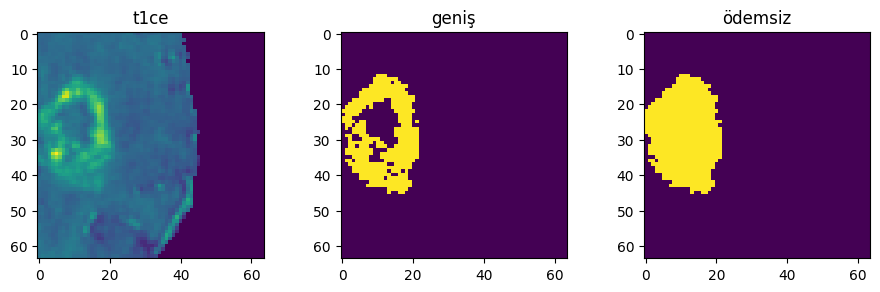

In [44]:
plt.figure(figsize=(15,10))


plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce_array[1190,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş_array[1190,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz_array[1190,0,:,:])

In [147]:
def unet_model_7():
  
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(batch7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(batch8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=dice_coef_loss,
        metrics=[dice_coef, iou_metric, precision, recall, f1_score]
    )

    return model


In [148]:
model_ödemsiz = unet_model_7() 

In [149]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(t1ce_array):
    print(f"\nFold {fold} başlıyor...")

   
    model_ödemsiz = unet_model_7() 


    X_train, X_val = t1ce_array[train_index], t1ce_array[val_index]
    y_train, y_val = ödemsiz_array[train_index], ödemsiz_array[val_index]


    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )


    model_ödemsiz.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=10,
        epochs=5,
        shuffle=True,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    model_ödemsiz.save_weights(f'repository/model_ödemsiz_fold_{fold}.weights.h5')
    print(f"Fold {fold} model ağırlıkları kaydedildi.")

    fold += 1



Fold 1 başlıyor...
Epoch 1/5


C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_946']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 968s 1s/step - dice_coef: 0.4811 - f1_score: 0.5587 - iou_metric: 0.4148 - loss: 0.5189 - precision: 0.4397 - recall: 0.9045 - val_dice_coef: 0.7589 - val_f1_score: 0.7624 - val_iou_metric: 0.6807 - val_loss: 0.2378 - val_precision: 0.7949 - val_recall: 0.7595
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 944s 1s/step - dice_coef: 0.7931 - f1_score: 0.8358 - iou_metric: 0.7309 - loss: 0.2069 - precision: 0.8120 - recall: 0.8875 - val_dice_coef: 0.7974 - val_f1_score: 0.8022 - val_iou_metric: 0.7207 - val_loss: 0.2019 - val_precision: 0.8139 - val_recall: 0.8166
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - dice_coef: 0.8565 - f1_score: 0.8717 - iou_metric: 0.7805 - loss: 0.1435 - precision: 0.8739 - recall: 0.8842 - val_dice_coef: 0.7557 - val_f1_score: 0.7588 - val_iou_metric: 0.6511 - val_loss: 0.2439 - val_precision: 0.6874 - val_recall: 0.8873
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 944s 1s/step - dice_coef: 0.8791 - f1_score: 0.8882 - iou_metric: 0.804

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_985']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 961s 1s/step - dice_coef: 0.4805 - f1_score: 0.5523 - iou_metric: 0.4099 - loss: 0.5195 - precision: 0.4360 - recall: 0.9023 - val_dice_coef: 0.7545 - val_f1_score: 0.7627 - val_iou_metric: 0.6922 - val_loss: 0.2419 - val_precision: 0.7461 - val_recall: 0.8033
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 953s 1s/step - dice_coef: 0.7826 - f1_score: 0.8237 - iou_metric: 0.7135 - loss: 0.2174 - precision: 0.7957 - recall: 0.8854 - val_dice_coef: 0.7546 - val_f1_score: 0.7664 - val_iou_metric: 0.7134 - val_loss: 0.2418 - val_precision: 0.8164 - val_recall: 0.7468
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - dice_coef: 0.8470 - f1_score: 0.8634 - iou_metric: 0.7686 - loss: 0.1530 - precision: 0.8663 - recall: 0.8775 - val_dice_coef: 0.7962 - val_f1_score: 0.8024 - val_iou_metric: 0.7461 - val_loss: 0.2000 - val_precision: 0.8192 - val_recall: 0.8121
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 950s 1s/step - dice_coef: 0.8847 - f1_score: 0.8910 - iou_metric: 0.809

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1024']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 977s 1s/step - dice_coef: 0.4957 - f1_score: 0.5649 - iou_metric: 0.4272 - loss: 0.5043 - precision: 0.4555 - recall: 0.9000 - val_dice_coef: 0.7635 - val_f1_score: 0.7756 - val_iou_metric: 0.6853 - val_loss: 0.2371 - val_precision: 0.7477 - val_recall: 0.8283
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 951s 1s/step - dice_coef: 0.7988 - f1_score: 0.8398 - iou_metric: 0.7356 - loss: 0.2012 - precision: 0.8127 - recall: 0.8953 - val_dice_coef: 0.7828 - val_f1_score: 0.7993 - val_iou_metric: 0.7351 - val_loss: 0.2176 - val_precision: 0.8477 - val_recall: 0.7716
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 949s 1s/step - dice_coef: 0.8525 - f1_score: 0.8662 - iou_metric: 0.7745 - loss: 0.1475 - precision: 0.8697 - recall: 0.8808 - val_dice_coef: 0.8096 - val_f1_score: 0.8114 - val_iou_metric: 0.7632 - val_loss: 0.1890 - val_precision: 0.8765 - val_recall: 0.7696
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 949s 1s/step - dice_coef: 0.8817 - f1_score: 0.8915 - iou_metric: 0.810

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1063']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 959s 1s/step - dice_coef: 0.4982 - f1_score: 0.5756 - iou_metric: 0.4348 - loss: 0.5018 - precision: 0.4630 - recall: 0.9048 - val_dice_coef: 0.7387 - val_f1_score: 0.7527 - val_iou_metric: 0.6574 - val_loss: 0.2577 - val_precision: 0.7147 - val_recall: 0.8197
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 949s 1s/step - dice_coef: 0.8096 - f1_score: 0.8485 - iou_metric: 0.7492 - loss: 0.1904 - precision: 0.8278 - recall: 0.8921 - val_dice_coef: 0.7774 - val_f1_score: 0.7868 - val_iou_metric: 0.7237 - val_loss: 0.2188 - val_precision: 0.8278 - val_recall: 0.7712
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 948s 1s/step - dice_coef: 0.8619 - f1_score: 0.8770 - iou_metric: 0.7885 - loss: 0.1381 - precision: 0.8821 - recall: 0.8843 - val_dice_coef: 0.7903 - val_f1_score: 0.7942 - val_iou_metric: 0.7432 - val_loss: 0.2059 - val_precision: 0.8471 - val_recall: 0.7646
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 950s 1s/step - dice_coef: 0.8807 - f1_score: 0.8882 - iou_metric: 0.804

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1102']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 956s 1s/step - dice_coef: 0.4797 - f1_score: 0.5480 - iou_metric: 0.4081 - loss: 0.5203 - precision: 0.4332 - recall: 0.9075 - val_dice_coef: 0.7390 - val_f1_score: 0.7460 - val_iou_metric: 0.6499 - val_loss: 0.2575 - val_precision: 0.6968 - val_recall: 0.8374
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 948s 1s/step - dice_coef: 0.8081 - f1_score: 0.8463 - iou_metric: 0.7444 - loss: 0.1919 - precision: 0.8238 - recall: 0.8923 - val_dice_coef: 0.7456 - val_f1_score: 0.7551 - val_iou_metric: 0.6572 - val_loss: 0.2508 - val_precision: 0.7328 - val_recall: 0.8176
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 949s 1s/step - dice_coef: 0.8527 - f1_score: 0.8671 - iou_metric: 0.7748 - loss: 0.1473 - precision: 0.8678 - recall: 0.8824 - val_dice_coef: 0.7758 - val_f1_score: 0.7794 - val_iou_metric: 0.7183 - val_loss: 0.2205 - val_precision: 0.8057 - val_recall: 0.7776
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 946s 1s/step - dice_coef: 0.8683 - f1_score: 0.8776 - iou_metric: 0.790

In [61]:
model_geniş = unet_model_7() 

In [64]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(t1ce_array):
    print(f"\nFold {fold} başlıyor...")

   
    model_geniş = unet_model_7() 


    X_train, X_val = t1ce_array[train_index], t1ce_array[val_index]
    y_train, y_val = geniş_array[train_index], geniş_array[val_index]


    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )


    model_geniş.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=10,
        epochs=5,
        shuffle=True,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    model_geniş.save_weights(f'repository/model_geniş_fold_{fold}.weights.h5')
    print(f"Fold {fold} model ağırlıkları kaydedildi.")

    fold += 1



Fold 1 başlıyor...
Epoch 1/5


C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_662']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 959s 1s/step - dice_coef: 0.3598 - f1_score: 0.4471 - iou_metric: 0.3072 - loss: 0.6402 - precision: 0.3163 - recall: 0.9440 - val_dice_coef: 0.6869 - val_f1_score: 0.7000 - val_iou_metric: 0.5677 - val_loss: 0.3102 - val_precision: 0.6280 - val_recall: 0.8261
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 936s 1s/step - dice_coef: 0.7012 - f1_score: 0.7622 - iou_metric: 0.6262 - loss: 0.2988 - precision: 0.6858 - recall: 0.8912 - val_dice_coef: 0.7237 - val_f1_score: 0.7295 - val_iou_metric: 0.6205 - val_loss: 0.2732 - val_precision: 0.7151 - val_recall: 0.7824
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 939s 1s/step - dice_coef: 0.7982 - f1_score: 0.8213 - iou_metric: 0.7025 - loss: 0.2018 - precision: 0.7904 - recall: 0.8720 - val_dice_coef: 0.7383 - val_f1_score: 0.7446 - val_iou_metric: 0.6452 - val_loss: 0.2601 - val_precision: 0.8201 - val_recall: 0.7074
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 947s 1s/step - dice_coef: 0.8243 - f1_score: 0.8367 - iou_metric: 0.724

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_701']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 970s 1s/step - dice_coef: 0.3804 - f1_score: 0.4730 - iou_metric: 0.3298 - loss: 0.6196 - precision: 0.3403 - recall: 0.9441 - val_dice_coef: 0.6758 - val_f1_score: 0.6856 - val_iou_metric: 0.5640 - val_loss: 0.3210 - val_precision: 0.5912 - val_recall: 0.8496
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - dice_coef: 0.7097 - f1_score: 0.7718 - iou_metric: 0.6372 - loss: 0.2903 - precision: 0.7031 - recall: 0.8856 - val_dice_coef: 0.6892 - val_f1_score: 0.6946 - val_iou_metric: 0.5845 - val_loss: 0.3075 - val_precision: 0.6343 - val_recall: 0.8186
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 964s 1s/step - dice_coef: 0.7979 - f1_score: 0.8205 - iou_metric: 0.7009 - loss: 0.2021 - precision: 0.7922 - recall: 0.8661 - val_dice_coef: 0.7470 - val_f1_score: 0.7535 - val_iou_metric: 0.6583 - val_loss: 0.2494 - val_precision: 0.6959 - val_recall: 0.8427
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - dice_coef: 0.8246 - f1_score: 0.8356 - iou_metric: 0.723

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_740']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 969s 1s/step - dice_coef: 0.3471 - f1_score: 0.4297 - iou_metric: 0.2934 - loss: 0.6529 - precision: 0.3020 - recall: 0.9392 - val_dice_coef: 0.6504 - val_f1_score: 0.6541 - val_iou_metric: 0.5256 - val_loss: 0.3494 - val_precision: 0.5497 - val_recall: 0.8530
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - dice_coef: 0.6933 - f1_score: 0.7547 - iou_metric: 0.6156 - loss: 0.3067 - precision: 0.6771 - recall: 0.8871 - val_dice_coef: 0.7299 - val_f1_score: 0.7421 - val_iou_metric: 0.6593 - val_loss: 0.2695 - val_precision: 0.7714 - val_recall: 0.7338
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 959s 1s/step - dice_coef: 0.7882 - f1_score: 0.8107 - iou_metric: 0.6883 - loss: 0.2118 - precision: 0.7822 - recall: 0.8628 - val_dice_coef: 0.6939 - val_f1_score: 0.7039 - val_iou_metric: 0.6250 - val_loss: 0.3027 - val_precision: 0.7894 - val_recall: 0.6594
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - dice_coef: 0.8192 - f1_score: 0.8282 - iou_metric: 0.712

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_779']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 969s 1s/step - dice_coef: 0.3419 - f1_score: 0.4194 - iou_metric: 0.2850 - loss: 0.6581 - precision: 0.2929 - recall: 0.9387 - val_dice_coef: 0.6704 - val_f1_score: 0.6768 - val_iou_metric: 0.5725 - val_loss: 0.3263 - val_precision: 0.6799 - val_recall: 0.7128
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 958s 1s/step - dice_coef: 0.6895 - f1_score: 0.7502 - iou_metric: 0.6100 - loss: 0.3105 - precision: 0.6675 - recall: 0.8918 - val_dice_coef: 0.7240 - val_f1_score: 0.7254 - val_iou_metric: 0.6371 - val_loss: 0.2725 - val_precision: 0.7579 - val_recall: 0.7206
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 961s 1s/step - dice_coef: 0.7858 - f1_score: 0.8082 - iou_metric: 0.6851 - loss: 0.2142 - precision: 0.7746 - recall: 0.8669 - val_dice_coef: 0.7134 - val_f1_score: 0.7149 - val_iou_metric: 0.6082 - val_loss: 0.2856 - val_precision: 0.6650 - val_recall: 0.8035
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 958s 1s/step - dice_coef: 0.8145 - f1_score: 0.8233 - iou_metric: 0.704

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_818']
Received: inputs=Tensor(shape=(None, 1, 64, 64))
  warnings.warn(msg)


749/749 ━━━━━━━━━━━━━━━━━━━━ 967s 1s/step - dice_coef: 0.3303 - f1_score: 0.4119 - iou_metric: 0.2776 - loss: 0.6697 - precision: 0.2844 - recall: 0.9436 - val_dice_coef: 0.6649 - val_f1_score: 0.6741 - val_iou_metric: 0.5595 - val_loss: 0.3319 - val_precision: 0.6428 - val_recall: 0.7483
Epoch 2/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 959s 1s/step - dice_coef: 0.6784 - f1_score: 0.7453 - iou_metric: 0.6053 - loss: 0.3216 - precision: 0.6633 - recall: 0.8894 - val_dice_coef: 0.7018 - val_f1_score: 0.7085 - val_iou_metric: 0.6083 - val_loss: 0.2948 - val_precision: 0.6640 - val_recall: 0.7916
Epoch 3/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 962s 1s/step - dice_coef: 0.7790 - f1_score: 0.8056 - iou_metric: 0.6807 - loss: 0.2210 - precision: 0.7703 - recall: 0.8661 - val_dice_coef: 0.7332 - val_f1_score: 0.7417 - val_iou_metric: 0.6301 - val_loss: 0.2633 - val_precision: 0.7034 - val_recall: 0.8046
Epoch 4/5
749/749 ━━━━━━━━━━━━━━━━━━━━ 962s 1s/step - dice_coef: 0.8224 - f1_score: 0.8335 - iou_metric: 0.718

In [70]:
model=unet_model()

In [71]:
model.load_weights('repository/tam_tumor.weights.h5')

C:\Users\Cem Yıldız\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 166 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [125]:
görüntü , koordinat = tümör_kırp(t1ce[200,:,:,:],seg_tam[200,:,:,:],64)

In [131]:

pred_tam = model.predict(x_train[199:200,:,:,:])


1/1 ━━━━━━━━━━━━━━━━━━━━ 285s 285s/step


In [151]:
pred_ödemsiz = model_ödemsiz.predict(görüntü)
pred_geniş = model_geniş.predict(görüntü)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


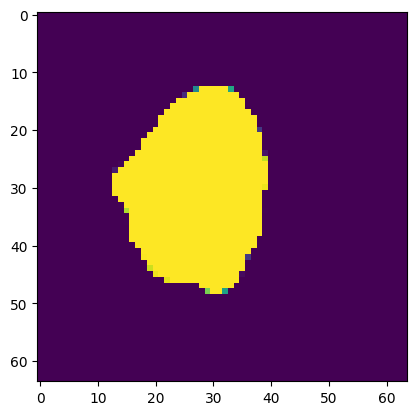

In [154]:
plt.imshow(pred_ödemsiz[0,0,:,:])

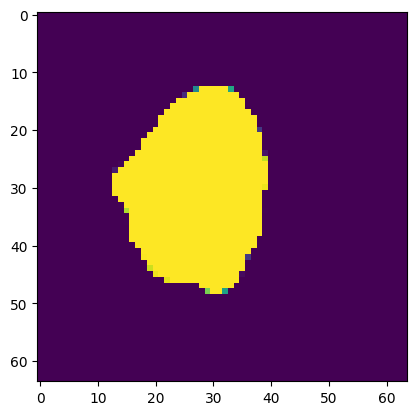

In [156]:
plt.imshow(pred_ödemsiz[0,0,:,:])

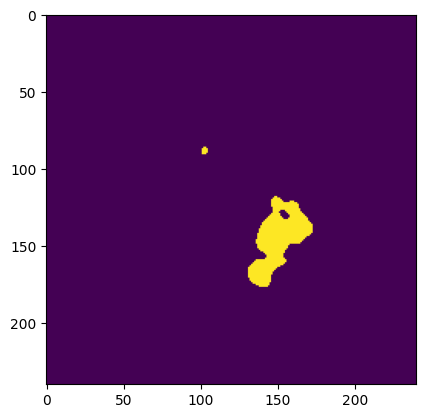

In [158]:
plt.imshow(pred_tam[0,0,:,:])

In [135]:
seg_orj = seg_array(r'C:\Users\Public\BraTS\train\\', '**\\*seg.nii.gz',0)

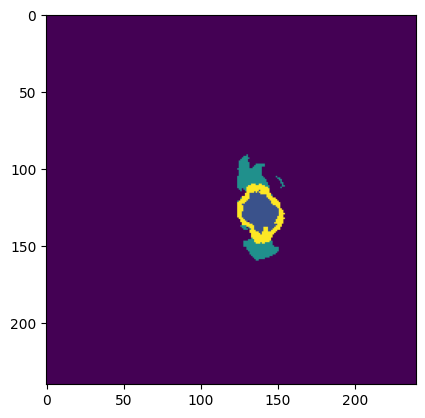

In [136]:
plt.imshow(seg_orj[,0,:,:])

In [137]:
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0

pred_ödemsiz[pred_ödemsiz > 0.2] = 1
pred_ödemsiz[pred_ödemsiz != 1 ] = 0

pred_geniş[pred_geniş > 0.2] = 4
pred_geniş[pred_geniş != 4 ] = 0


In [138]:
def üstüne_ekle(pred_tam, pred_ödemsiz , pred_geniş , koordinat):  
    
    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_tam[:,:,:]
    
    for i in range(pred_ödemsiz.shape[0]):
        for j in range(64):
            for k in range(64):
                
                if pred_ödemsiz[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_ödemsiz[i,0,j,k]
                    
                if pred_geniş[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_geniş[i,0,j,k]
                
    return total

In [139]:
deneme = üstüne_ekle(pred_tam[0,:,:,:], pred_ödemsiz, pred_geniş, koordinat)

In [140]:
deneme.shape

(1, 240, 240)

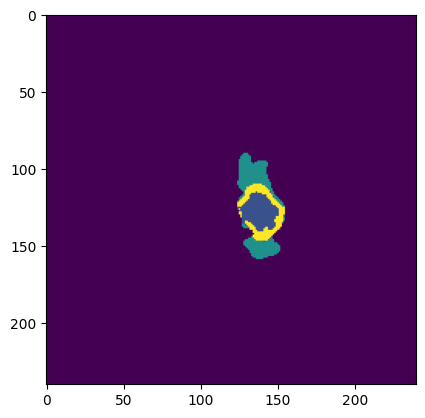

In [141]:
plt.imshow(deneme[0])

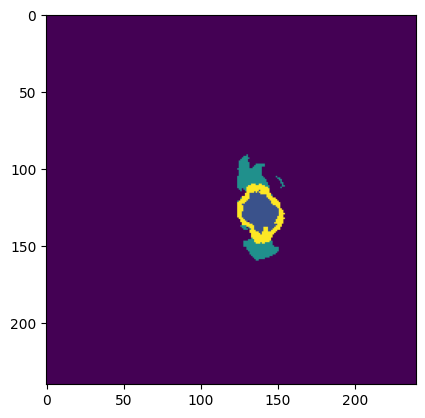

In [142]:
plt.imshow(seg_orj[200,0,:,:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 286s 286s/step


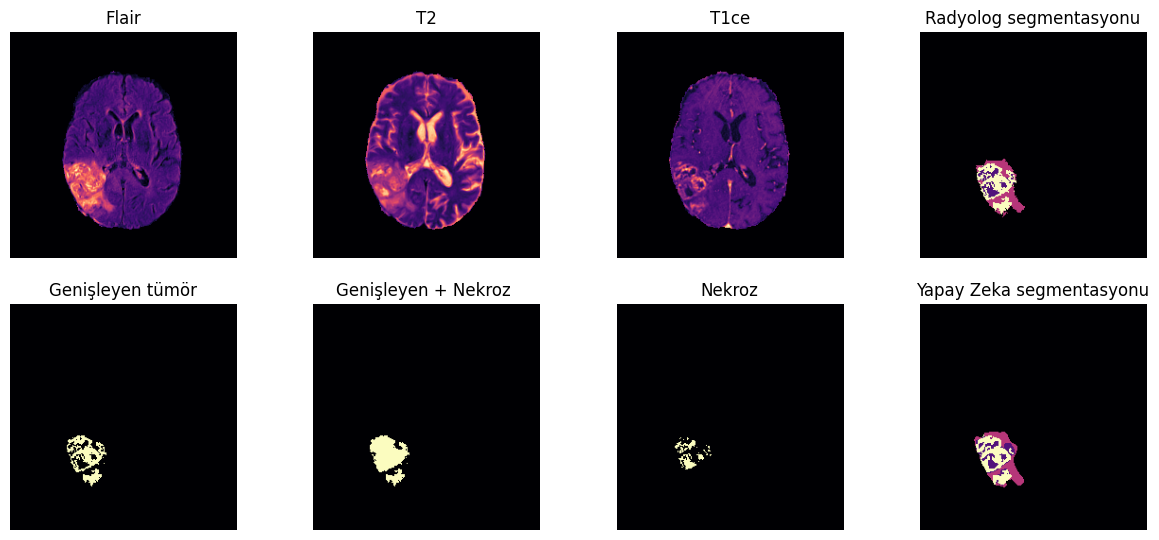

In [161]:
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 0
x = 6386

görüntü , koordinat = tümör_kırp(t1ce[x,:,:,:],seg_tam[x,:,:,:],64)
pred_ödemsiz = model_ödemsiz.predict(görüntü)
pred_geniş = model_geniş.predict(görüntü)
pred_tam = model.predict(x_train[x-1:x,:,:,:])
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0
pred_ödemsiz[pred_ödemsiz > 0.2] = 1
pred_ödemsiz[pred_ödemsiz != 1 ] = 0
pred_geniş[pred_geniş > 0.2] = 4
pred_geniş[pred_geniş != 4 ] = 0
deneme = üstüne_ekle(pred_tam[0,:,:,:], pred_ödemsiz, pred_geniş, koordinat)


plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('Flair')
plt.axis('off')
plt.imshow(x_train[x, 0, :, :],cmap= renk[a])

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(x_train[x, 1, :, :],cmap= renk[a])
    
plt.subplot(343)
plt.title('T1ce')
plt.axis('off')
plt.imshow(t1ce[x, 0, :, :],cmap= renk[a])

plt.subplot(344)
plt.title('Radyolog segmentasyonu')
plt.axis('off')
plt.imshow(seg_orj[x, 0, :, :],cmap= renk[a])

plt.subplot(345)
plt.title('Genişleyen tümör')
plt.axis('off')
plt.imshow(seg_geniş[x, 0, :, :],cmap= renk[a])

plt.subplot(346)
plt.title('Genişleyen + Nekroz ')
plt.axis('off')
plt.imshow(seg_ödemsiz[x, 0, :, :],cmap= renk[a])

plt.subplot(347)
plt.title('Nekroz')
plt.axis('off')
plt.imshow(seg_nekroz[x, 0, :, :],cmap= renk[a])

plt.subplot(348)
plt.title('Yapay Zeka segmentasyonu')
plt.axis('off')
plt.imshow(deneme[ 0, :, :],cmap=renk[a])

